<a href="https://colab.research.google.com/github/louissiller/mgmt467-analytics-portfolio/blob/main/Unit3/Lab1_bts_batch_etl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Plan: From Historical Analysis to Real-Time Flight Predictions

This plan is broken down into the three parts you've outlined. Each part will be a section in the final Colab notebook, with clear instructions and code cells.

# **Part I: Batch Processing of Historical Flight Data**

Objective: To build a foundational understanding of data engineering and machine learning using a large, static dataset.

Cell-by-Cell Plan:

Setup and Authentication:

Install necessary libraries (google-cloud-storage, google-cloud-bigquery, pandas, db-dtypes).

Authenticate the user and configure the GCP project.

Define all necessary variables (bucket names, dataset names, etc.).

Data Acquisition (Downloading 2024 Flight Data):

Provide a function that programmatically downloads the 2024 On-Time Performance data directly from the BTS.gov website. We will select a few months to keep the dataset manageable.

The code will download the zipped CSV files and then unzip them.

Move Data to GCS Bucket:

Create a new GCS bucket.

Upload the downloaded and unzipped CSV files to this bucket. This establishes our "data lake."

Load Data into a BigQuery Table:

Create a new BigQuery dataset.

Use a BigQuery Load Job to load all the CSV files from the GCS bucket into a single BigQuery table. We will use schema auto-detection.

Data Cleaning and Feature Engineering in BigQuery:

Run SQL queries to inspect the data, handle nulls, and create new features. A key feature will be creating a boolean label for logistic regression, such as is_arrival_delayed (TRUE if ARR_DELAY > 15 minutes).

Build a Linear Regression Model:

Use BigQuery ML to create a linear regression model to predict a continuous variable.

Goal: Predict ARR_DELAY based on features like DEP_DELAY, CARRIER, DISTANCE, and DAY_OF_WEEK.

Include cells to create, evaluate, and make predictions with the model.

Build a Logistic Regression Model:

Use BigQuery ML to create a logistic regression model for classification.

Goal: Predict the is_arrival_delayed boolean label we created earlier.

Include cells to create, evaluate (checking precision/recall), and make predictions.

Build a K-Means Clustering Model:

Use BigQuery ML to create a K-Means clustering model to segment the data.

Goal: Group flights into clusters based on their characteristics (e.g., "long-haul, often delayed," "short-haul, on-time").

Include cells to create the model and analyze the resulting cluster centroids to understand their meaning.

# **Part II: Micro-Batch Processing of "Live" Data**

Objective: To simulate a streaming environment where new data arrives periodically and build a pipeline to process it.

Cell-by-Cell Plan:

Introduction to Streaming Concepts:

Explain the difference between batch and streaming. Introduce the OpenSky Network API as our source for live flight data.

Build a Cloud Function for Data Ingestion (GCS Trigger):

Provide the Python code for a Google Cloud Function.

Function's Job: This function will be triggered on a schedule (e.g., every 15 minutes using Cloud Scheduler). It will call the OpenSky Network API, fetch all current flight vectors, format the data as a JSON file, and save it to a new GCS bucket (our "streaming landing zone").

Set up the Pub/Sub and BigQuery Streaming Infrastructure:

Create a Pub/Sub topic that will receive notifications about new files.

Configure the GCS bucket to send a message to this Pub/Sub topic every time a new file is created.

Create a new BigQuery table to hold the streaming data.

Build a Dataflow Pipeline (Pub/Sub to BigQuery):

Provide the code for a second Cloud Function (or a Dataflow job) that is triggered by messages on the Pub/Sub topic.

Function's Job: When triggered, it will read the new JSON file from GCS, parse it, and stream the data into the new BigQuery table.

Build ML Models on the Streaming Data:

Re-run the same BigQuery ML CREATE MODEL statements from Part I, but this time, train them on the new BigQuery table that is being populated with the streaming data. This demonstrates how models can be updated with fresh data.

## **Part III: Real-Time Prediction**

Objective: To build a true real-time pipeline that makes predictions on individual events as they happen.

Cell-by-Cell Plan:

Architecting for Real-Time:

Explain why for true real-time, we want to bypass saving files to GCS and send data directly to a message queue.

Build a Cloud Function for Direct Streaming (Pub/Sub):

Provide the code for a new, optimized Cloud Function.

Function's Job: This function will be triggered by a scheduler. It will fetch data from the OpenSky API and publish each flight's data as a separate message directly to a new Pub/Sub topic.

Real-Time Prediction Pipeline:

Provide the code for a final Cloud Function that acts as our real-time prediction engine.

Function's Job: This function will be a subscriber to the Pub/Sub topic from the previous step. For each message (each flight) it receives, it will immediately call the ML.PREDICT function using the models developed in Part II.

The prediction results (e.g., "this flight is likely to be delayed") can then be saved to a separate "predictions" table in BigQuery.

Visualizing Real-Time Results:

Include a final set of BigQuery queries that students can run to see the predictions populating the new table in near real-time.

In [5]:
# @title ### Cell 1: Setup, Authentication, and Configuration (Corrected)
# @markdown **Objective:** This cell imports all necessary Python libraries, authenticates your Google account to allow access to your GCP project, and sets up key configuration variables.

# ---
# **Libraries Explained:**
# - `os`: For interacting with the operating system, like removing files.
# - `requests`: A standard library for making HTTP requests to download files from the web.
# - `zipfile`: For working with ZIP archives, allowing us to extract the downloaded data.
# - `subprocess`: Allows us to run shell commands like `gcloud` and `gsutil` directly from Python.
# - `re`: The regular expressions library, used here for cleaning text data.
# - `datetime`: For handling dates and looping through the required time period.
# - `google.colab.auth`: A specific Colab library to handle authentication with your Google account.
# ---

import os
import requests
import zipfile
import subprocess
import re
from datetime import datetime
from google.colab import auth

def setup_environment():
    """
    Authenticates the user and configures the necessary GCP project and bucket names.

    This function handles the initial setup by authenticating the user's Google account
    for use within the Colab environment. It then programmatically determines the
    current GCP Project ID. If it cannot be determined automatically, it will prompt
    the user to enter it manually. It also prompts the user for a base bucket name
    and combines it with the project ID to ensure global uniqueness.

    Returns:
        tuple: A tuple containing the Project ID and the generated GCS bucket name.
               Returns (None, None) if the project ID or bucket name is not provided.
    """
    print("Authenticating your Google account...")
    # This command will trigger a pop-up to authenticate your Google account.
    auth.authenticate_user()
    print("✅ Authentication successful.")

    project_id = ""
    try:
        # This command runs the gcloud CLI to get the currently configured project ID.
        project_id_process = subprocess.run(
            ["gcloud", "config", "get-value", "project"],
            capture_output=True, text=True, check=True
        )
        project_id = project_id_process.stdout.strip()
    except (subprocess.CalledProcessError, FileNotFoundError):
        # This block will run if gcloud is not configured or not found.
        pass

    if not project_id:
        print("⚠️ Could not automatically determine GCP Project ID.")
        project_id = input("Please enter your GCP Project ID: ")

    if not project_id:
        print("🔴 ERROR: Project ID is required to continue. Halting execution.")
        return None, None

    print(f"✅ Using GCP Project: {project_id}")

    # --- EDIT: Ask for the bucket name from the user ---
    base_bucket_name = input("Please enter a base name for your GCS bucket (e.g., 'flight-data'): ")
    if not base_bucket_name:
        print("🔴 ERROR: A base name for the bucket is required. Halting execution.")
        return project_id, None

    # GCS bucket names must be globally unique and cannot contain dots or start with underscores.
    # We create a safe, unique name by combining the project ID and the user's input.
    safe_project_id = project_id.replace('.', '-')
    bucket_name = f"{safe_project_id}-{base_bucket_name}"
    print(f"✅ Bucket will be named: {bucket_name}")
    return project_id, bucket_name

# Run the setup function and store the variables.
PROJECT_ID, BUCKET_NAME = setup_environment()

Authenticating your Google account...
✅ Authentication successful.
⚠️ Could not automatically determine GCP Project ID.
Please enter your GCP Project ID: mgmt467-71800
✅ Using GCP Project: mgmt467-71800
Please enter a base name for your GCS bucket (e.g., 'flight-data'): flight-data
✅ Bucket will be named: mgmt467-71800-flight-data


In [6]:
# @title ### Cell 2: Create GCS Bucket (Corrected)
# @markdown **Objective:** This cell checks if the required Google Cloud Storage (GCS) bucket exists, and if not, it creates it.

def create_gcs_bucket_if_not_exists(bucket_name, project_id):
    """
    Checks for the existence of a GCS bucket and creates it if it's not found.

    This function uses the `gsutil` command-line tool to interact with GCS.
    It first tries to list the contents of the target bucket. If this command
    fails, it assumes the bucket does not exist and proceeds to create it
    using `gsutil mb` (make bucket).

    Args:
        bucket_name (str): The name of the GCS bucket to check and create.
        project_id (str): The GCP project ID to associate with the bucket creation.
    """
    if not bucket_name or not project_id:
        print("🔴 ERROR: Bucket name or Project ID is not set. Cannot proceed.")
        return

    print(f"\nChecking for GCS bucket: gs://{bucket_name}")
    try:
        # The `gsutil ls` command will fail if the bucket does not exist.
        subprocess.run(["gsutil", "ls", f"gs://{bucket_name}"], check=True, capture_output=True)
        print(f"✅ Bucket gs://{bucket_name} already exists.")
    except subprocess.CalledProcessError:
        print(f"Bucket not found. Creating gs://{bucket_name}...")
        # `gsutil mb` creates a new bucket.
        try:
            # --- FIX: Added the '-p [project_id]' flag to the gsutil command ---
            subprocess.run(
                ["gsutil", "mb", "-p", project_id, f"gs://{bucket_name}"],
                check=True, capture_output=True, text=True
            )
            print(f"✅ Bucket gs://{bucket_name} created.")
        except subprocess.CalledProcessError as e:
            print(f"🔴 ERROR: Failed to create bucket. The name may be taken or invalid.")
            print(f"   Details: {e.stderr}")


# Run the bucket creation function using the globally defined variables.
create_gcs_bucket_if_not_exists(BUCKET_NAME, PROJECT_ID)


Checking for GCS bucket: gs://mgmt467-71800-flight-data
✅ Bucket gs://mgmt467-71800-flight-data already exists.


In [11]:
# @title ### Cell 3: Define the Data Download and Preparation Function
# @markdown **Objective:** This cell defines the main worker function, `download_and_prepare_month`, which handles the entire ETL (Extract, Transform, Load) process for a single month's data.

def download_and_prepare_month(year, month, bucket_name):
    """
    Downloads, unzips, cleans, and uploads data for a specific month and year.

    This function encapsulates the logic from the shell script's `prepareMonthData`
    function, performing the following steps:
    1.  Constructs the download URL and downloads the ZIP file using `requests`.
    2.  Extracts the contents of the ZIP file using `zipfile`.
    3.  Finds the specific CSV file for the month and cleans it by removing
        trailing commas and all quotation marks, replicating the `sed` commands.
    4.  Uploads the cleaned CSV file to a specific folder within the GCS bucket.
    5.  Cleans up all temporary local files.

    Args:
        year (int): The year of the data to download.
        month (int): The month of the data to download.
        bucket_name (str): The GCS bucket to upload the final data to.
    """
    print(f"\n--- Preparing data for {month:02d}/{year} ---")

    # 1. Download the data file from BTS.gov
    print("  Downloading...")
    url = f"https://transtats.bts.gov/PREZIP/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_{year}_{month}.zip"
    downloaded_zip_file = f"{year}-{month}.zip"

    try:
        # We use requests.get() to download the file.
        # `verify=False` is used to bypass potential SSL certificate issues, similar to `curl -k`.
        response = requests.get(url, verify=False, timeout=300)
        response.raise_for_status()  # This will raise an HTTPError for bad responses (4xx or 5xx)
        with open(downloaded_zip_file, 'wb') as f:
            f.write(response.content)
    except requests.exceptions.RequestException as e:
        print(f"  🔴 ERROR: Cannot download data for {month}/{year}. URL may be invalid or server is down. {e}")
        return

    # 2. Unzip the downloaded file
    print("  Unzipping...")
    try:
        with zipfile.ZipFile(downloaded_zip_file, 'r') as zip_ref:
            zip_ref.extractall(".")
    except zipfile.BadZipFile:
        print(f"  🔴 ERROR: Failed to unzip file for {month}/{year}. It may not be a valid zip archive.")
        if os.path.exists(downloaded_zip_file):
            os.remove(downloaded_zip_file)
        return

    # 3. Clean the extracted CSV data
    print("  Cleaning...")
    cleaned_csv_file = f"{year}-{month}.csv"
    original_csv_name = None
    # Find the CSV file that was just unzipped.
    for file in os.listdir("."):
        if file.endswith(f"_{year}_{month}.csv"):
            original_csv_name = file
            break

    if not original_csv_name:
        print(f"  🔴 ERROR: No CSV file found after unzipping for {month}/{year}.")
        if os.path.exists(downloaded_zip_file): os.remove(downloaded_zip_file)
        return

    # Read the original file, clean each line, and write to a new file.
    with open(original_csv_name, 'r', encoding='utf-8', errors='ignore') as infile, \
         open(cleaned_csv_file, 'w', encoding='utf-8') as outfile:
        for line in infile:
            # Replicates `sed -e 's/,$//g' -e 's/"//g'`
            # 1. Remove trailing comma if it exists.
            # 2. Remove all quotation marks.
            cleaned_line = re.sub(r',?$', '', line.strip()).replace('"', '')
            outfile.write(cleaned_line + '\n')

    # 4. Upload the cleaned file to Google Cloud Storage
    print("  Storing in GCS...")
    destination_blob_name = f"data/flightsETL/{cleaned_csv_file}"
    try:
        # Use `gsutil cp` to copy the local file to the GCS bucket.
        subprocess.run(
            ["gsutil", "cp", cleaned_csv_file, f"gs://{bucket_name}/{destination_blob_name}"],
            check=True, capture_output=True
        )
        print(f"  ✅ Successfully uploaded {cleaned_csv_file}")
    except subprocess.CalledProcessError as e:
        print(f"  🔴 ERROR: Failed to upload to GCS. {e.stderr.decode()}")

    # 5. Clean up all local files to save space
    print("  Cleaning up local files...")
    if os.path.exists(downloaded_zip_file): os.remove(downloaded_zip_file)
    if os.path.exists(original_csv_name): os.remove(original_csv_name)
    if os.path.exists(cleaned_csv_file): os.remove(cleaned_csv_file)
    # Also remove any other potential extracted files like readme.html
    if os.path.exists("readme.html"): os.remove("readme.html")

In [12]:
# @title ### Cell 4: Main Execution Loop
# @markdown **Objective:** This cell defines the date range for the data download and then loops through each month, calling the worker function defined in the previous cell.

def run_pipeline():
    """
    Manages the overall execution flow. It sets the date range and iterates
    through each month, calling the data preparation function.
    """
    if not BUCKET_NAME:
        print("🔴 ERROR: BUCKET_NAME is not defined. Halting execution.")
        return

    # --- Define Date Range ---
    # You can change these values to download a different range of data.
    start_year, start_month = 2024, 1  # Start: January 2024
    end_year, end_month = 2024, 3      # End: March 2024

    print(f"Starting pipeline to download data from {start_month}/{start_year} to {end_month}/{end_year}.")

    # --- Loop Through Dates ---
    current_date = datetime(start_year, start_month, 1)
    end_date = datetime(end_year, end_month, 1)

    while current_date <= end_date:
        download_and_prepare_month(current_date.year, current_date.month, BUCKET_NAME)

        # Increment the date to the next month
        # This logic correctly handles rolling over to the next year.
        next_month = current_date.month + 1
        next_year = current_date.year
        if next_month > 12:
            next_month = 1
            next_year += 1
        current_date = datetime(next_year, next_month, 1)

    print("\n--- Pipeline Execution Complete ---")

# Execute the main pipeline function.
run_pipeline()

Starting pipeline to download data from 1/2024 to 3/2024.

--- Preparing data for 01/2024 ---
  Downloading...


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'transtats.bts.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


  Unzipping...
  Cleaning...
  Storing in GCS...
  ✅ Successfully uploaded 2024-1.csv
  Cleaning up local files...

--- Preparing data for 02/2024 ---
  Downloading...


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'transtats.bts.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


  Unzipping...
  Cleaning...
  Storing in GCS...
  ✅ Successfully uploaded 2024-2.csv
  Cleaning up local files...

--- Preparing data for 03/2024 ---
  Downloading...


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'transtats.bts.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


  Unzipping...
  Cleaning...
  Storing in GCS...
  ✅ Successfully uploaded 2024-3.csv
  Cleaning up local files...

--- Pipeline Execution Complete ---


In [13]:
# @title ### Cell 5: Final Verification
# @markdown **Objective:** This final cell runs the `gsutil ls -l` command to list the contents of the target GCS directory. This allows you to verify that all the cleaned CSV files were successfully uploaded.

def verify_uploads(bucket_name):
    """
    Lists the final contents of the target GCS directory to verify uploads.
    """
    if not bucket_name:
        print("🔴 ERROR: BUCKET_NAME is not defined. Cannot verify.")
        return

    target_directory = f"gs://{bucket_name}/data/flightsETL/"
    print(f"\nVerifying final contents of {target_directory}...")

    try:
        # Use subprocess to run the gsutil command and capture its output.
        result = subprocess.run(
            ["gsutil", "ls", "-l", target_directory],
            check=True, capture_output=True, text=True
        )
        print("✅ Uploads confirmed:")
        print(result.stdout)
    except subprocess.CalledProcessError as e:
        print(f"🔴 ERROR: Could not list directory contents. It may be empty or there was an error.")
        print(e.stderr)

# Run the verification function.
verify_uploads(BUCKET_NAME)


Verifying final contents of gs://mgmt467-71800-flight-data/data/flightsETL/...
✅ Uploads confirmed:
 198123150  2025-11-06T20:32:13Z  gs://mgmt467-71800-flight-data/data/flightsETL/2024-1.csv
 188194543  2025-11-06T20:33:38Z  gs://mgmt467-71800-flight-data/data/flightsETL/2024-2.csv
 215000314  2025-11-06T20:35:09Z  gs://mgmt467-71800-flight-data/data/flightsETL/2024-3.csv
TOTAL: 3 objects, 601318007 bytes (573.46 MiB)



In [14]:
# @title ### Cell 6: Create BigQuery Dataset
# @markdown **Objective:** This cell creates a new dataset in BigQuery to store our flight data. A dataset is a container for your tables, similar to a schema in a traditional database.

from google.cloud import bigquery
from google.cloud.exceptions import Conflict

# Initialize the BigQuery client
client = bigquery.Client(project=PROJECT_ID)

# Define the name for your new BigQuery dataset
BIGQUERY_DATASET = "flights_data"
dataset_id = f"{PROJECT_ID}.{BIGQUERY_DATASET}"

try:
    # Create a Dataset object
    dataset = bigquery.Dataset(dataset_id)
    # Specify the location for the dataset
    dataset.location = "US" # You can change this to your preferred location
    # Make an API request to create the dataset
    client.create_dataset(dataset, timeout=30)
    print(f"✅ Successfully created dataset: {dataset_id}")
except Conflict:
    print(f"✅ Dataset '{dataset_id}' already exists.")
except Exception as e:
    print(f"🔴 An error occurred: {e}")

✅ Successfully created dataset: mgmt467-71800.flights_data


In [15]:
# @title ### Cell 7: Load All CSVs from GCS into a BigQuery Table
# @markdown **Objective:** This cell uses a BigQuery Load Job to efficiently load all the cleaned CSV files from your GCS bucket into a single BigQuery table. This is the recommended method for batch loading from GCS.

# Define the name for the new table
BIGQUERY_TABLE = "flights_raw"
table_id = f"{PROJECT_ID}.{BIGQUERY_DATASET}.{BIGQUERY_TABLE}"

# Configure the Load Job
job_config = bigquery.LoadJobConfig(
    # Automatically infer the schema from the data.
    autodetect=True,
    # Skip the first row of each file, which contains the headers.
    skip_leading_rows=1,
    # The source format is CSV.
    source_format=bigquery.SourceFormat.CSV,
    # Allow for rows that might have too few columns.
    allow_jagged_rows=True,
    # Overwrite the table if it already exists.
    write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE,
)

# Define the GCS URI using a wildcard to select all CSV files in the folder
uri = f"gs://{BUCKET_NAME}/data/flightsETL/*.csv"

try:
    # Start the Load Job
    load_job = client.load_table_from_uri(
        uri, table_id, job_config=job_config
    )
    print(f"🚀 Starting BigQuery load job {load_job.job_id}...")

    # Waits for the job to complete.
    load_job.result()
    print("✅ Load job finished.")

    # Get the destination table object and print the row count
    destination_table = client.get_table(table_id)
    print(f"Loaded {destination_table.num_rows} rows into table '{BIGQUERY_TABLE}'.")

except Exception as e:
    print(f"🔴 An error occurred: {e}")

🚀 Starting BigQuery load job 1b737ee5-9ba0-4aca-8b39-197a159d0f65...
✅ Load job finished.
Loaded 1658259 rows into table 'flights_raw'.


In [16]:
# @title ### Cell 8: Data Cleaning and Feature Engineering (Corrected)
# @markdown **Objective:** This cell runs a SQL query to create a new, cleaned view of our data. This view will serve as the basis for our machine learning models. We will create a key boolean label, `is_arrival_delayed`, for our classification model.

# Define the name for our new view
CLEANED_VIEW = "flights_cleaned"
view_id = f"{PROJECT_ID}.{BIGQUERY_DATASET}.{CLEANED_VIEW}"

# This SQL query selects relevant columns and creates our new feature.
# A VIEW is a virtual table based on the result-set of an SQL statement.
# It's a great way to create a clean dataset without duplicating data.
# --- FIX: Using the correct column names from the provided schema ---
sql_query = f"""
CREATE OR REPLACE VIEW `{view_id}` AS
SELECT
  -- Construct a DATE type from Year, Month, DayofMonth columns
  PARSE_DATE('%Y%m%d', CONCAT(CAST(Year AS STRING), LPAD(CAST(Month AS STRING), 2, '0'), LPAD(CAST(DayofMonth AS STRING), 2, '0'))) AS FL_DATE,
  IATA_CODE_Reporting_Airline AS CARRIER,
  Origin,
  Dest,
  DepDelay,
  ArrDelay,
  Distance,
  CAST(DayOfWeek AS STRING) AS DAY_OF_WEEK,
  -- Create a boolean label: TRUE if arrival delay is > 15 mins, FALSE otherwise.
  -- We also treat NULL delays as not delayed.
  CASE
    WHEN ArrDelay > 15 THEN TRUE
    ELSE FALSE
  END AS is_arrival_delayed
FROM
  `{table_id}`
WHERE
  -- Filter out cancelled and diverted flights for accurate modeling
  Cancelled = 0 AND Diverted = 0;
"""

try:
    # Execute the query to create the view
    query_job = client.query(sql_query)
    query_job.result() # Wait for the job to complete
    print(f"✅ Successfully created cleaned view: {CLEANED_VIEW}")

    # Verify by showing the first 10 rows of the new view
    print("\n--- Sample of Cleaned Data ---")
    df = client.query(f"SELECT * FROM `{view_id}` LIMIT 10").to_dataframe()
    display(df)

except Exception as e:
    print(f"🔴 An error occurred: {e}")

✅ Successfully created cleaned view: flights_cleaned

--- Sample of Cleaned Data ---


,FL_DATE,CARRIER,Origin,Dest,DepDelay,ArrDelay,Distance,DAY_OF_WEEK,is_arrival_delayed
0,2024-03-14,9E,ATL,30135,950,1150,96.0,4,True
1,2024-02-22,9E,ATL,30135,955,1155,103.0,4,True
2,2024-01-05,9E,ATL,30135,2112,2315,95.0,5,True
3,2024-03-27,OH,CLT,30135,2227,11,63.0,3,False
4,2024-02-22,G4,DEN,30135,1200,1747,175.0,4,True
5,2024-01-01,OO,ORD,30135,1800,2100,99.0,1,True
6,2024-03-20,OO,ORD,30135,1813,2119,82.0,3,True
7,2024-03-03,G4,PIE,30135,1902,2133,128.0,7,True
8,2024-03-29,G4,SFB,30135,1822,2049,141.0,5,True
9,2024-03-29,MQ,DFW,30136,859,957,36.0,5,True


In [17]:
# @title ### Cell 9: Build, Evaluate, and Predict with a Linear Regression Model
# @markdown **Objective:** Use BigQuery ML to create a linear regression model to predict the arrival delay (`ARR_DELAY`).

from google.cloud import bigquery
from google.cloud.exceptions import NotFound # Import NotFound for specific error handling

# Re-initialize the BigQuery client to ensure it's fresh and correctly scoped
client = bigquery.Client(project=PROJECT_ID)

# Re-define necessary variables as they might have been cleared
CLEANED_VIEW = "flights_cleaned"
view_id = f"{PROJECT_ID}.{BIGQUERY_DATASET}.{CLEANED_VIEW}"

print(f"Attempting to use view: {view_id}")

# --- Add a check for view existence before proceeding ---
try:
    client.get_table(view_id) # get_table works for views too
    print(f"✅ BigQuery view '{view_id}' confirmed to exist.")
except NotFound:
    print(f"🔴 ERROR: BigQuery view '{view_id}' not found. Please ensure Cell 8 (Data Cleaning and Feature Engineering) ran successfully and created the view.")
    raise # Re-raise the error to stop execution if the view is truly not found
except Exception as e:
    print(f"🔴 An unexpected error occurred while checking view existence: {e}")
    raise

# --- 1. Create the Linear Regression Model ---
print("🚀 Training Linear Regression model...")
create_linear_model_query = f"""
CREATE OR REPLACE MODEL `{PROJECT_ID}.{BIGQUERY_DATASET}.flight_delay_predictor`
OPTIONS(model_type='LINEAR_REG', input_label_cols=['ArrDelay']) AS
SELECT
  ArrDelay,
  DepDelay,
  CARRIER,
  Distance,
  DAY_OF_WEEK
FROM
  `{view_id}`;
"""
linear_job = client.query(create_linear_model_query)
linear_job.result()
print("✅ Linear Regression model created successfully.")

# --- 2. Evaluate the Model ---
print("\n--- Model Evaluation ---")
evaluate_linear_model_query = f"""
SELECT * FROM ML.EVALUATE(MODEL `{PROJECT_ID}.{BIGQUERY_DATASET}.flight_delay_predictor`);
"""
linear_eval_df = client.query(evaluate_linear_model_query).to_dataframe()
display(linear_eval_df)

# --- 3. Make Predictions with the Model ---
print("\n--- Sample Predictions ---")
predict_linear_query = f"""
SELECT
  ArrDelay AS actual_delay,
  predicted_ArrDelay
FROM
  ML.PREDICT(MODEL `{PROJECT_ID}.{BIGQUERY_DATASET}.flight_delay_predictor`,
    (SELECT * FROM `{view_id}` LIMIT 10));
"""
linear_predict_df = client.query(predict_linear_query).to_dataframe()
display(linear_predict_df)

Attempting to use view: mgmt467-71800.flights_data.flights_cleaned
✅ BigQuery view 'mgmt467-71800.flights_data.flights_cleaned' confirmed to exist.
🚀 Training Linear Regression model...
✅ Linear Regression model created successfully.

--- Model Evaluation ---


,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,192.550844,134107.363118,0.35035,127.854618,0.489373,0.48939



--- Sample Predictions ---


,actual_delay,predicted_ArrDelay
0,1620,1574.898517
1,1620,1566.611609
2,1400,1409.339423
3,2141,1960.493910
4,1835,1752.507022
5,1732,1687.017291
6,1655,1688.633888
7,1128,1265.841457
8,726,974.363542
9,1911,1845.187305


In [18]:
# @title ### Cell 10: Build, Evaluate, and Predict with a Logistic Regression Model
# @markdown **Objective:** Use BigQuery ML to create a logistic regression model to predict if a flight will be significantly delayed (`is_arrival_delayed`).

# --- 1. Create the Logistic Regression Model ---
print("🚀 Training Logistic Regression model...")
create_logistic_model_query = f"""
CREATE OR REPLACE MODEL `{PROJECT_ID}.{BIGQUERY_DATASET}.flight_delay_classifier`
OPTIONS(model_type='LOGISTIC_REG', input_label_cols=['is_arrival_delayed']) AS
SELECT
  *
FROM
  `{view_id}`;
"""
logistic_job = client.query(create_logistic_model_query)
logistic_job.result()
print("✅ Logistic Regression model created successfully.")

# --- 2. Evaluate the Model ---
print("\n--- Model Evaluation ---")
evaluate_logistic_model_query = f"""
SELECT * FROM ML.EVALUATE(MODEL `{PROJECT_ID}.{BIGQUERY_DATASET}.flight_delay_classifier`);
"""
logistic_eval_df = client.query(evaluate_logistic_model_query).to_dataframe()
display(logistic_eval_df)

# --- 3. Make Predictions with the Model ---
print("\n--- Sample Predictions ---")
# --- FIX: Changed 'prob' to the correct column name 'predicted_is_arrival_delayed_probs' ---
predict_logistic_query = f"""
SELECT
  is_arrival_delayed AS actual_is_delayed,
  predicted_is_arrival_delayed,
  predicted_is_arrival_delayed_probs
FROM
  ML.PREDICT(MODEL `{PROJECT_ID}.{BIGQUERY_DATASET}.flight_delay_classifier`,
    (SELECT * FROM `{view_id}` LIMIT 10))
"""
logistic_predict_df = client.query(predict_logistic_query).to_dataframe()
display(logistic_predict_df)

🚀 Training Logistic Regression model...
✅ Logistic Regression model created successfully.

--- Model Evaluation ---


,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.996507,1.0,0.99651,0.998251,0.00973,0.996975



--- Sample Predictions ---


,actual_is_delayed,predicted_is_arrival_delayed,predicted_is_arrival_delayed_probs
0,True,True,"[{'label': True, 'prob': 0.996372761816112}, {..."
1,True,True,"[{'label': True, 'prob': 0.9967615498612433}, ..."
2,True,True,"[{'label': True, 'prob': 0.9991067333575372}, ..."
3,True,True,"[{'label': True, 'prob': 0.997766341756952}, {..."
4,True,True,"[{'label': True, 'prob': 0.9997626418995256}, ..."
5,True,True,"[{'label': True, 'prob': 0.9998614462283829}, ..."
6,True,True,"[{'label': True, 'prob': 0.9998225841011144}, ..."
7,True,True,"[{'label': True, 'prob': 0.9996624854898792}, ..."
8,True,True,"[{'label': True, 'prob': 0.9990644071583314}, ..."
9,True,True,"[{'label': True, 'prob': 0.9994129588662504}, ..."


In [19]:
# @title ### Cell 11: Build and Analyze a K-Means Clustering Model
# @markdown **Objective:** Use BigQuery ML's K-Means to group flights into distinct clusters based on their characteristics.

# --- 1. Create the K-Means Clustering Model ---
print("🚀 Training K-Means Clustering model...")
create_kmeans_model_query = f"""
CREATE OR REPLACE MODEL `{PROJECT_ID}.{BIGQUERY_DATASET}.flight_clusterer`
OPTIONS(model_type='KMEANS', num_clusters=5) AS
SELECT
  DepDelay,
  ArrDelay,
  Distance
FROM
  `{view_id}`
WHERE DepDelay IS NOT NULL AND ArrDelay IS NOT NULL;
"""
kmeans_job = client.query(create_kmeans_model_query)
kmeans_job.result()
print("✅ K-Means Clustering model created successfully.")

# --- 2. Analyze the Cluster Centroids ---
print("\n--- Cluster Centroid Analysis ---")
# ML.CENTROIDS shows the average values for each feature within each cluster.
# This helps us understand what defines each cluster (e.g., Cluster 1 is short-haul flights with minor delays).
analyze_centroids_query = f"""
SELECT
  *
FROM
  ML.CENTROIDS(MODEL `{PROJECT_ID}.{BIGQUERY_DATASET}.flight_clusterer`);
"""
centroids_df = client.query(analyze_centroids_query).to_dataframe()
display(centroids_df)

# --- 3. See which Cluster Each Flight Belongs To ---
print("\n--- Sample Cluster Assignments ---")
predict_kmeans_query = f"""
SELECT
  CENTROID_ID,
  DepDelay,
  ArrDelay,
  Distance
FROM
  ML.PREDICT(MODEL `{PROJECT_ID}.{BIGQUERY_DATASET}.flight_clusterer`,
    (SELECT * FROM `{view_id}` LIMIT 10));
"""
kmeans_predict_df = client.query(predict_kmeans_query).to_dataframe()
display(kmeans_predict_df)

🚀 Training K-Means Clustering model...
✅ K-Means Clustering model created successfully.

--- Cluster Centroid Analysis ---


,centroid_id,feature,numerical_value,categorical_value
0,1,DepDelay,1387.068247,[]
1,1,ArrDelay,1414.476151,[]
2,1,Distance,76.558286,[]
3,2,DepDelay,1874.713209,[]
4,2,ArrDelay,2083.358549,[]
5,2,Distance,96.145750,[]
6,3,DepDelay,765.483292,[]
7,3,ArrDelay,971.163206,[]
8,3,Distance,103.571275,[]
9,4,DepDelay,1404.076196,[]



--- Sample Cluster Assignments ---


,CENTROID_ID,DepDelay,ArrDelay,Distance
0,1,2227,11,73.0
1,2,1710,1854,82.0
2,2,2109,2251,82.0
3,2,1652,1919,131.0
4,2,1822,2049,122.0
5,3,942,1132,71.0
6,2,1854,2143,93.0
7,3,955,1155,103.0
8,1,1457,1659,98.0
9,3,957,1224,110.0


Visualizing K-Means Cluster Centroids...


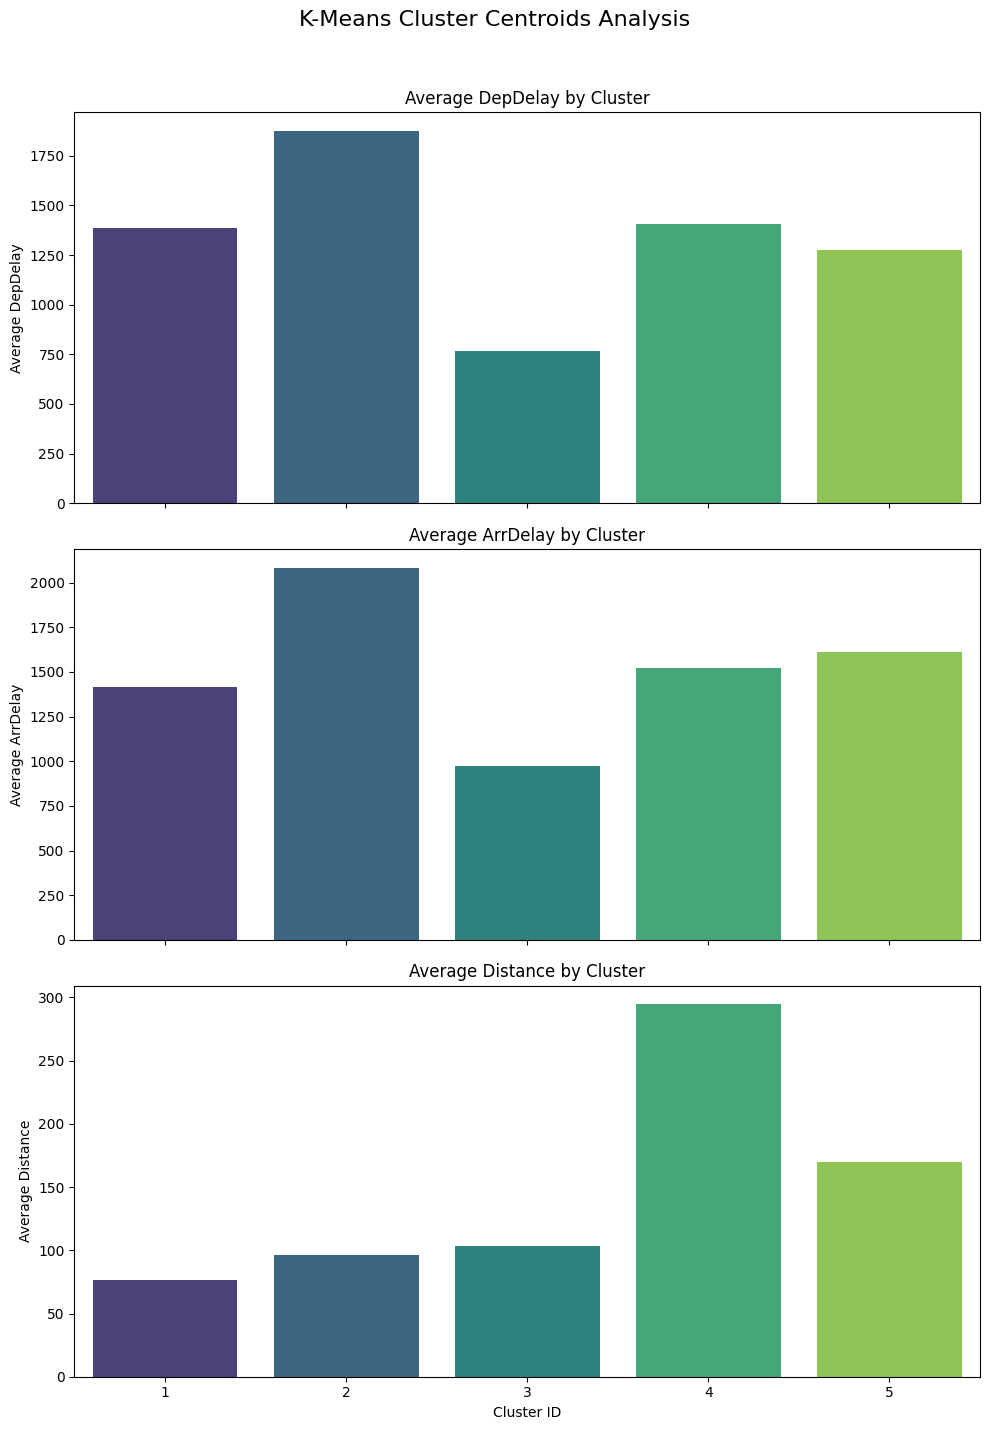

✅ Visualization complete.


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure centroids_df is available, if not, re-run the previous cell or load it.
# Assuming centroids_df is already in the environment from Cell 11.

print("Visualizing K-Means Cluster Centroids...")

# Reshape the centroids_df for easier plotting
# The current format has features as rows, we want them as columns per centroid

# Filter out categorical_value column for numerical plotting
centroids_num_df = centroids_df[centroids_df['feature'].isin(['DepDelay', 'ArrDelay', 'Distance'])]

# Pivot the table to have features as columns and centroid_id as index
centroids_pivot_df = centroids_num_df.pivot(index='centroid_id', columns='feature', values='numerical_value')

# Plotting
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15), sharex=True)
fig.suptitle('K-Means Cluster Centroids Analysis', fontsize=16)

features = ['DepDelay', 'ArrDelay', 'Distance']
colors = sns.color_palette("viridis", n_colors=len(centroids_pivot_df))

for i, feature in enumerate(features):
    sns.barplot(x=centroids_pivot_df.index, y=feature, data=centroids_pivot_df, ax=axes[i], palette=colors, hue=centroids_pivot_df.index, legend=False)
    axes[i].set_title(f'Average {feature} by Cluster')
    axes[i].set_ylabel(f'Average {feature}')
    axes[i].set_xlabel('Cluster ID')

plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust layout to prevent suptitle overlap
plt.show()

print("✅ Visualization complete.")

The bar charts above show the average values for `DepDelay`, `ArrDelay`, and `Distance` for each of the 5 clusters identified by the K-Means model.

*   **Interpretation**: By examining these charts, you can infer the characteristics of each cluster. For example, a cluster with high `DepDelay` and `ArrDelay` but low `Distance` might represent short-haul flights with significant delays, while a cluster with high `Distance` and moderate delays might represent longer-haul flights.

This visualization helps in understanding what defines each group of flights that the model has identified.